# Useful resources

**General:**
* Bash commands: `cat` for concatenating, `grep` for pattern search
* `redundant_seq_remover.py`

**For NCBI:**
* XML parser

**For AphidBase:**
* XML parser

**For OrthoFinder:**
* `split_fasta_by_species.py`

# (Down)loading packages

In [1]:
!pip install numpy
!pip install pandas
!pip install Bio
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
from Bio import SeqIO, Entrez
from Bio.Blast import NCBIWWW, NCBIXML
import re
import seaborn as sns

Entrez.email = "elian.strozyk@etu.umontpellier.fr"

# Extracting sequences

Sequences are retrieved using their NCBI ID and the Entrez and SeqIO modules from Biopython.

In [2]:
# All stylins identified and their NCBI ID
# 01, 02, 03, 04, 04bis, 05
NCBI_gene_ID = ["NM_001162314.1",
                "NM_001162671.2",
                "NM_001161959.2",
                "NM_001172260.1",
                "NM_001172268.2",
                "NM_001163252.1"
               ]

NCBI_protein_ID = ["NP_001155786.1",
                   "NP_001156143.1",
                   "NP_001155431.1",
                   "NP_001165731.1",
                   "NP_001165739.1",
                   "NP_001156724.1"
                  ]

## Retrieving DNA

In [3]:
dna_search_results = Entrez.efetch("Nucleotide",
                                   id = ",".join(NCBI_gene_ID),
                                   rettype = "fasta"
                                  )
dna_records = SeqIO.parse(dna_search_results, "fasta")
#write a fasta file with stylin's sequences
SeqIO.write(dna_records, "./stylin_dna_sequence.fasta", "fasta")
dna_search_results.close()

## Retrieving proteins

In [4]:
protein_search_results = Entrez.efetch("Protein",
                                       id = ",".join(NCBI_protein_ID),
                                       rettype = "fasta"
                                      )
protein_records = SeqIO.parse(protein_search_results, "fasta")
# write a fasta file with stylin's sequences
SeqIO.write(protein_records, "./stylin_protein_sequence.fasta", "fasta")
protein_search_results.close()

# Data mining (proteins and *Aphididae*)

Here, we mostly work with proteins because scoring matrices (for aligning) are more modulable than those for nucleic sequences due to the alphabet size.

Stylin orthologs are retrieved using different databases.
Three databases were used:
* NCBI (BLASTp and BLASTx: available with Biopython)
* BIPAA's AphidBase (BLAST online: not available with command lines)
* MetaPhOrs (not available with command lines)

AphidBase is a database that focuses on arthropods, it contains aphid genomes not referenced in NCBI.

MetaPhOrs is a database that aims to find orthologs and paralogs in species with a reference genome. It combines multiple repositories. In our case, this database does not provide enough results with the default parameters. Moreover, it lacks many filtering options.

## NCBI

NCBI's BLAST can be run with Biopython's qblast() function.

The qblast() function doesn't seem to work with several sequences:
* With one sequence as input, it will return several sequences
* With several sequences as input, it will return only one sequence

As such, a way to avoid this problem is to run as many BLASTs as stylin sequences. This method is not very optimised, I might have to check other Python libraries.

BLAST's parameters were changed to match the online ones in order to retrieve as many sequences as possible. Parameters were also aligned with those of AphidBase's BLAST.

### blastp

First, we run a blastp. the XML output was not saved because the files were empty for some reason. Instead, the unique IDs were saved into a list. Afterwards, all sequences are saved into a single fasta file.

In [6]:
hit_ids_p = [] # stores all returned protein's IDs 
for stylin in NCBI_protein_ID :
    result_handle = NCBIWWW.qblast(program = "blastp",
                                   database = "nr",
                                   sequence = stylin,
                                   entrez_query = "Aphididae[Organism]",
                                   expect = 0.01,
                                   gapcosts = "11 1",
                                   hitlist_size = 250,
                                   word_size = 3,
                                   matrix_name = "BLOSUM62"
                                  )
    blast_records = NCBIXML.parse(result_handle)
    for blast_record in blast_records :
        for alignment in blast_record.alignments :
            if alignment.hit_id not in hit_ids_p :
                hit_ids_p.append(alignment.hit_id) # append all HSP IDs
    result_handle.close()
    blast_records.close()

A few stats and saving protein IDs and a multifasta containing all sequences.

In [23]:
# storing all sequences as a fasta file
protein_search_results = Entrez.efetch("Protein",
                                       id = ",".join(hit_ids_p),
                                       rettype = "fasta"
                                      )
protein_records = SeqIO.parse(protein_search_results, "fasta")
SeqIO.write(protein_records, "./orthologs_blastp.ncbi.fasta", "fasta")
protein_search_results.close()

Plotting the results to make it eye-catching.

Sitobion avenae : 1
Aphis glycines : 22
Aphis craccivora : 26
Sipha flava : 30
Diuraphis noxia : 30
Melanaphis sacchari : 33
Myzus persicae : 34
Rhopalosiphum maidis : 34
Cinara cedri : 36
Acyrthosiphon pisum : 43
Aphis gossypii : 49


Text(0, 0.5, 'Count')

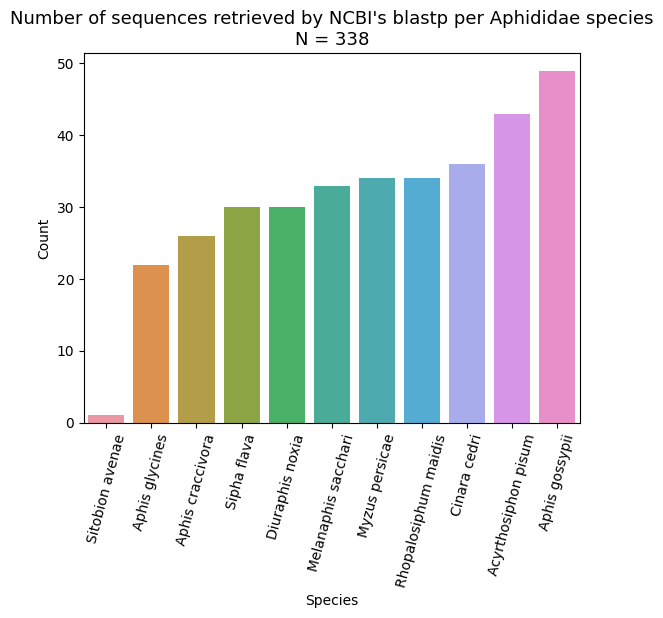

In [30]:
# Creation of a dictionary to store all species and their count
dictionary = {}
with open("orthologs_blastp.ncbi.fasta", "r") as file :
    for line in file :
        for key in re.findall("\[(.*)\]", line) :
            if key not in dictionary :
                dictionary[key] = 1
            else :
                dictionary[key] += 1
                
# sorting the dictionary by ascending values
dictionary = dict(sorted(dictionary.items(), key = lambda item: item[1]))
                
# printing the dictionary
for key in dictionary :
    print(f"{key} : {dictionary[key]}")
    

# Storing the total number of species
speciesTotalNumber = sum(dictionary.values())
    
# plotting the dictionary
plot = sns.barplot(x = list(dictionary.keys()),
                   y = list(dictionary.values())
                  )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 75)
plot.set_title(f"Number of sequences retrieved by NCBI's blastp per Aphididae species\nN = {speciesTotalNumber}",
               size = 13)
plot.set_xlabel("Species")
plot.set_ylabel("Count")

Only sequences from 10 species of *Aphididae* were retrieved. We must find a way to increase the species count, because *Aphididae* contain way more than 10 species.

### blastx

We run a BLASTX to see whether we can can increase the species count.

Sitobion avenae : 1
Aphis glycines : 20
Aphis craccivora : 22
Sipha flava : 26
Diuraphis noxia : 27
Rhopalosiphum maidis : 29
Melanaphis sacchari : 29
Myzus persicae : 30
Cinara cedri : 33
Acyrthosiphon pisum : 38
Aphis gossypii : 44


Text(0, 0.5, 'Count')

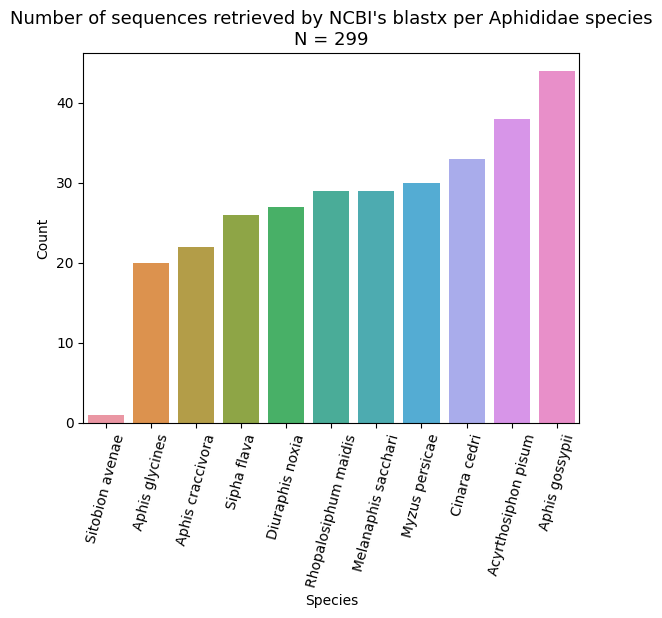

In [29]:
# storing species count in a dictionary
dictionary = {}
with open("orthologs_blastx.ncbi.fasta", "r") as file :
    for line in file :
        for key in re.findall("\[(.*)\]", line) :
            if key not in dictionary :
                dictionary[key] = 1
            else :
                dictionary[key] += 1
                
# sorting the dictionary by ascending values
dictionary = dict(sorted(dictionary.items(), key = lambda item: item[1]))
                
# printing the dictionary
for key in dictionary :
    print(f"{key} : {dictionary[key]}")
    

# Storing the total number of species
speciesTotalNumber = sum(dictionary.values())
    
# plotting the dictionary
plot = sns.barplot(x = list(dictionary.keys()),
                   y = list(dictionary.values())
                  )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 75)
plot.set_title(f"Number of sequences retrieved by NCBI's blastx per Aphididae species\nN = {speciesTotalNumber}",
               size = 13)
plot.set_xlabel("Species")
plot.set_ylabel("Count")

### tblastn

In [5]:
hit_ids_tn = [] # stores all returned protein's IDs 
for stylin in NCBI_protein_ID :
    result_handle = NCBIWWW.qblast(program = "tblastn",
                                   database = "nr",
                                   sequence = stylin,
                                   entrez_query = "Aphididae[Organism]",
                                   expect = 0.01,
                                   gapcosts = "11 1",
                                   hitlist_size = 250,
                                   word_size = 5,
                                   matrix_name = "BLOSUM62"
                                  )
    blast_records = NCBIXML.parse(result_handle)
    for blast_record in blast_records :
        for alignment in blast_record.alignments :
            if alignment.hit_id not in hit_ids_tn :
                hit_ids_tn.append(alignment.hit_id) # append all HSP IDs
    result_handle.close()
    blast_records.close()

The output of the BLAST is different from the previous ones. Each element contains two IDs concatenated with a pipe. Both IDs return the same result. 

In [83]:
hit_ids_tn_cleaned = []
hit_ids_tn_cleaned2 = []
for element in hit_ids_tn :
    hit_ids_tn_cleaned.append(re.findall("(gi\|\d+)\|", element))
hit_ids_tn_cleaned2 = [''.join(id) for id in hit_ids_tn_cleaned]

# storing all sequences as a fasta file
protein_search_results = Entrez.efetch(db = "nucleotide",
                                       id = ",".join(hit_ids_tn_cleaned2),
                                       rettype = "fasta"
                                      )
protein_records = SeqIO.parse(protein_search_results, "fasta")
SeqIO.write(protein_records, "orthologs_tblastn.ncbi.fasta", "fasta")
protein_search_results.close()

Brevicoryne brassicae : 1
Aphis craccivora : 1
Sitobion avenae : 1
Periphyllus acericola : 7
Drepanosiphum platanoidis : 9
Diuraphis noxia : 25
Rhopalosiphum maidis : 27
Melanaphis sacchari : 27
Sipha flava : 27
Myzus persicae : 32
Aphis gossypii : 36
Acyrthosiphon pisum : 61


Text(0, 0.5, 'Count')

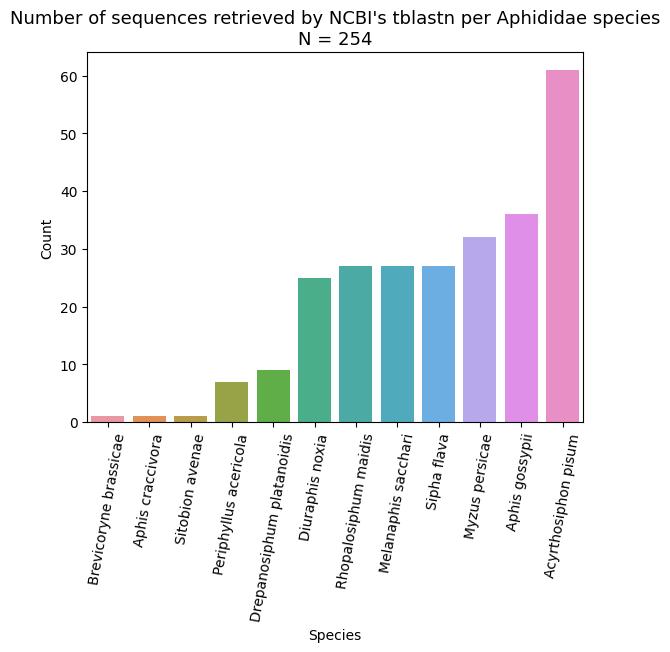

In [27]:
# storing species count in a dictionary
dictionary = {}
with open("orthologs_tblastn.ncbi.fasta", "r") as file :
    for record in SeqIO.parse(file, "fasta") :
        match = re.findall("([A-Z][a-z]+ [a-z]+)", record.description) # find species name in the header
        match = ''.join(match) # transform a list into a simple string without apostrophes and brackets
        if match not in dictionary :
            dictionary[match] = 1
        else :
            dictionary[match] += 1
            
# sorting the dictionary by ascending values
dictionary = dict(sorted(dictionary.items(), key = lambda item: item[1]))
            
# printing dictionary's keys and values
for key in dictionary :
    print(f"{key} : {dictionary[key]}")
    
# Storing the total number of species
speciesTotalNumber = sum(dictionary.values())

# plotting the dictionary
plot = sns.barplot(x = list(dictionary.keys()),
                   y = list(dictionary.values())
                  )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 80)
plot.set_title(f"Number of sequences retrieved by NCBI's tblastn per Aphididae species\nN = {speciesTotalNumber}",
               size = 13)
plot.set_xlabel("Species")
plot.set_ylabel("Count")

The species count remains low regardless of the BLAST algorithm. Another way to retrieve sequences from more species would be to blast genome assemblies. However, it would cause a problem with the current stylin sequences since those are cDNA and so don't contain any introns. Moreover, it seems to be possible to blast against genome assemblies using BioPython with replacing the `database` argument but it returns no sequence for some reason.

## MetaPhOrs

The orthologs resulting from querying this database are obtained for any species and there is no option to filter taxa. Plus, you can only query one sequence at a time. As such, sequences belonging to the *Aphididae* clade were filtered by hands because they were not numerous. However, this will be complicated with clades deeper in the phylogenetic tree.

Missing stylin sequences among the six already known were appended.

Cinara cedri : 6
Myzus persicae : 6
Acyrthosiphon pisum : 10


Text(0, 0.5, 'Count')

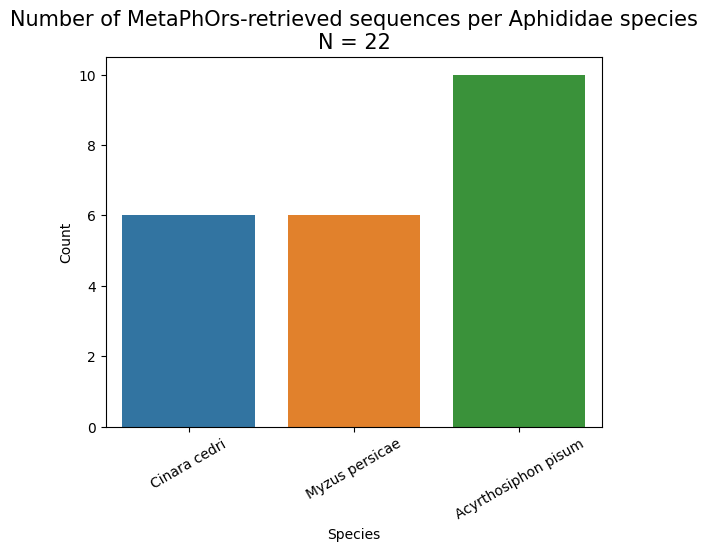

In [32]:
# counting species number in a dictionary
speciesCounter = {}
with open("../metaphors/stylin_orthologs_aphididae.metaphors.fasta") as fd :
    for line in fd :
        for key in re.findall("\[(.*)\]", line) :
            if key not in speciesCounter :
                speciesCounter[key] = 1
            else :
                speciesCounter[key] += 1
                   
# sorting the dictionary by ascending values
speciesCounter = dict(sorted(speciesCounter.items(), key = lambda item: item[1]))
            
# printing dictionary's keys and values
for key in speciesCounter :
    print(f"{key} : {speciesCounter[key]}")
    
# Storing the total number of species
speciesTotalNumber = sum(speciesCounter.values())

# plotting the dictionary
plot = sns.barplot(x = list(speciesCounter.keys()),
                   y = list(speciesCounter.values())
                  )
plot.set_xticklabels(plot.get_xticklabels(), rotation = 30)
plot.set_title(f"Number of MetaPhOrs-retrieved sequences per Aphididae species\nN = {speciesTotalNumber}",
               size = 15)
plot.set_xlabel("Species")
plot.set_ylabel("Count")

## BIPAA's AphidBase (WIP)

AphidBase contains 11 aphid genomes. It can run BLAST, but it can only apply to a single at a time.

Parameters:
* **program = blastp**
* search_type = normal
* **sequence**
* databank_type = public
* databank = ???
* **expect = 0.01**
* word_size = 3
* **max_target_sequences = 250**
* matrix = BLOSUM62
* gap_costs = 11 1
* composition_adjustments = conditional_compositional_score

# Orthologous relationships

Orthologous relationships were checked with OrthoFinder. It can be run with command lines. The input is a directory containing as many fasta files as necessary: each file represents one species and contains all sequences belonging to that species. I had to write a script to sort the sequences per species named `split_fasta_by_species.py`. This script assumes the header contains the species name written like this: `[Myzus persicae]`.

We will focus on orthogroups containing stylin sequences and those that seem interesing (early orthogroups for example).

In [9]:
from Bio import Phylo # loading the package

## BLASTp's results

First, OrthoFinder was run using the output of the first BLASTp and the default parameters: `./orthofinder -f work/blastp_ncbi/`

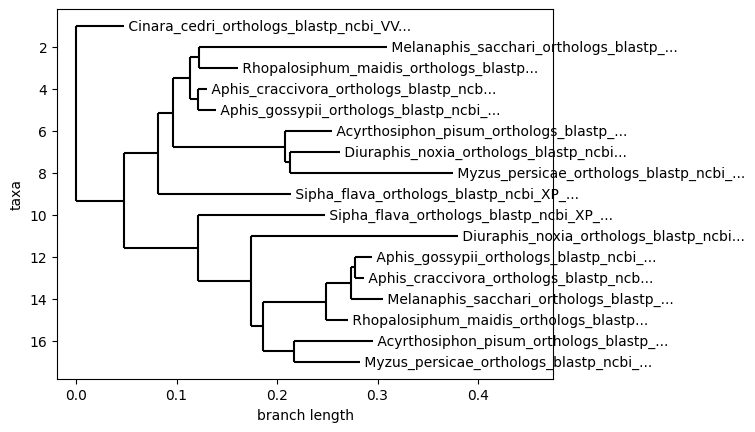

In [20]:
with open("./Results_May17/Gene_Trees/OG0000001_tree.txt") as tree :
    nwk = Phylo.read(tree, "newick")
    Phylo.draw(nwk)

# Summary

* Extraction of stylin's DNA and protein sequences
* Protein orthologs were retrieved from databases: NCBI, MetaPhOrs
* Orthologous relationships were tested using OrthoFinder

# Improvements

* Run a single BLAST with all sequences instead of 6 BLASTs with one sequence.
* Find orthologs with AphidBase, write a script that transforms XML to fasta file.
* Check whether it's possible to blast genome assemblies using BioPython